Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following:
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ISIC/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/ISIC/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size = batch_size,
                                                               image_size = (img_height,img_width),
                                                               seed = 123,
                                                               validation_split = 0.2,
                                                               subset = 'training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             batch_size = batch_size,
                                                             image_size = (img_height,img_width),
                                                             seed = 123,
                                                             validation_split = 0.2,
                                                             subset = 'validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


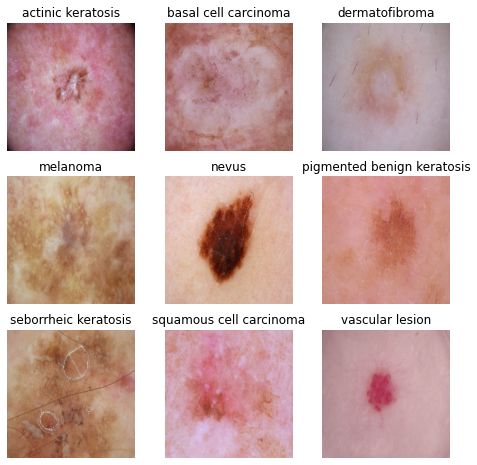

In [10]:
plt.figure(figsize=(8,8))
for i in range(len(class_names)):
   filter = train_ds.filter(lambda x, l: l[0]==i)
   for image, label in filter:
       plt.subplot(3, 3, i+1)
       plt.imshow(image[0].numpy().astype('uint8'))
       plt.title(class_names[label.numpy()[0]])
       plt.axis('off')

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [12]:
### Your code goes here
model = Sequential()
# add a layer to rescale the RGB channel values
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(len(class_names), activation = 'softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 16)        2

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/20
56/56 [==============================] - 114s 2s/step - loss: 2.0138 - accuracy: 0.2327 - val_loss: 1.9091 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 47s 832ms/step - loss: 1.7104 - accuracy: 0.3839 - val_loss: 1.5170 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 49s 872ms/step - loss: 1.4178 - accuracy: 0.5078 - val_loss: 1.4072 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 49s 877ms/step - loss: 1.3517 - accuracy: 0.5240 - val_loss: 1.3839 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 47s 835ms/step - loss: 1.3456 - accuracy: 0.5195 - val_loss: 1.4456 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 49s 872ms/step - loss: 1.1997 - accuracy: 0.5798 - val_loss: 1.3737 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 47s 844ms/step - loss: 1.1495 - accuracy: 0.5859 - val_loss: 1.4271 - val_accuracy: 0.5414
E

### Visualizing training results

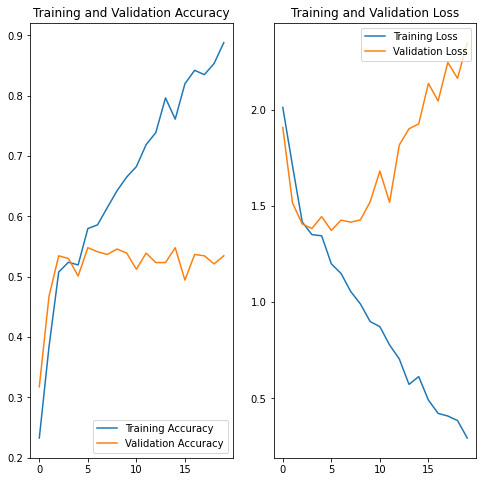

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Finding: There is a clear evidence of overfit: training accuracy is much higher than validation accuracy after the 10th epoch, and validation accuracy is low (around 50%). In term of loss, training loss decreases after each epoch, whereas validation loss increases after the 10th epoch.

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

# Augumentation strategy: create random images from training dataset to increase the number of training images, thus overfitting is reduced.
# Some augumentation techniques that can be used are perspective skewing, rotating, flipping, gaussian noise, etc.
# We will use Keras data augumentation to create a layer of augumentation that consists of random flip, random rotation and gaussian noise.
augmentation = Sequential([layers.RandomFlip(input_shape=(img_height,img_width,3), mode="horizontal_and_vertical", seed = 123),
                                 layers.RandomRotation(0.5, seed = 123),
                                 layers.GaussianNoise(5)])


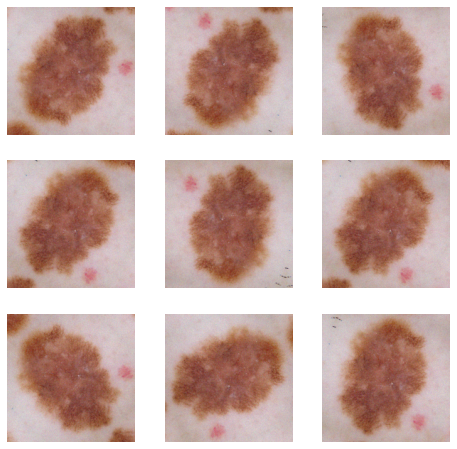

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(8,8))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = augmentation(images,training = True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model2 = Sequential([augmentation])
# add a layer to rescale the RGB channel values
model2.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model2.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model2.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(2,2))

model2.add(Dropout(0.1))
model2.add(Flatten())
model2.add(Dense(512, activation = 'relu'))
model2.add(Dense(len(class_names), activation = 'softmax'))


### Compiling the model

In [20]:
## Your code goes here
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                  

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
history = model2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/20
56/56 [==============================] - 56s 987ms/step - loss: 2.1092 - accuracy: 0.2003 - val_loss: 2.0270 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 55s 983ms/step - loss: 1.8600 - accuracy: 0.3186 - val_loss: 1.5961 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 57s 1s/step - loss: 1.5745 - accuracy: 0.4408 - val_loss: 1.4843 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 55s 988ms/step - loss: 1.5622 - accuracy: 0.4609 - val_loss: 1.4271 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 55s 982ms/step - loss: 1.4098 - accuracy: 0.5156 - val_loss: 1.4270 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 56s 1s/step - loss: 1.3869 - accuracy: 0.5240 - val_loss: 1.3610 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 55s 991ms/step - loss: 1.3446 - accuracy: 0.5262 - val_loss: 1.4723 - val_accuracy: 0.4787
Epoch

### Visualizing the results

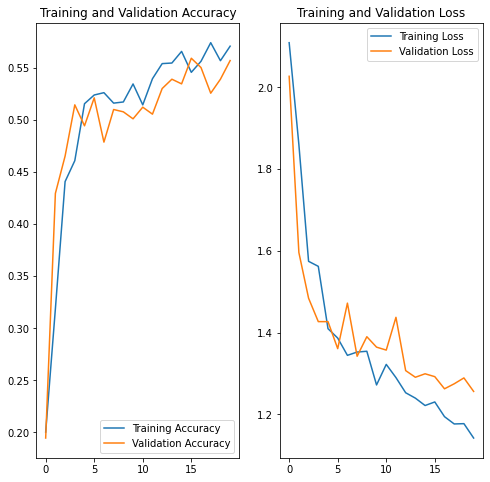

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Finding: after using augumentation and adding a dropout layer, training accuracy and validation accuracy are quite similar. Validation accuracy also increases compared to previous model, so there is some improvement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.

# Check distribution of classes in training folder:
class_distribution = {}
for i in class_names:
  class_distribution[i] = len(list(data_dir_train.glob(i+'/*.jpg')))
class_distribution

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [25]:
# Check distribution of classes in training dataset (after splitting training folder into training dataset and validation dataset)
train_label = np.concatenate([label for img, label in train_ds], axis=0)

In [26]:
# Create a dictionary to convert numerical class label into class names:
convert = {i:class_names[i] for i in range(9)}

In [27]:
# convert numerical class label into class names and count:
converted_name = np.vectorize(convert.get)(train_label)
labels, counts = np.unique(converted_name, return_counts=True)

In [28]:
np.asarray((labels, counts)).T

array([['actinic keratosis', '92'],
       ['basal cell carcinoma', '309'],
       ['dermatofibroma', '77'],
       ['melanoma', '352'],
       ['nevus', '277'],
       ['pigmented benign keratosis', '370'],
       ['seborrheic keratosis', '58'],
       ['squamous cell carcinoma', '142'],
       ['vascular lesion', '115']], dtype='<U26')

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples: 'seborrheic keratosis' has the least number of samples both before and after the training-validation split.
#### - Which classes dominate the data in terms proportionate number of samples: 'pigmented benign keratosis' dominates the data both before and after the training-validation split.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset= "/content/gdrive/MyDrive/ISIC/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAE7ACD110>: 100%|██████████| 500/500 [00:27<00:00, 18.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAE7A9B150>: 100%|██████████| 500/500 [00:26<00:00, 19.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAEAEA0A10>: 100%|██████████| 500/500 [00:26<00:00, 19.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FDAEB5EDC90>: 100%|██████████| 500/500 [01:57<00:00,  4.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FDAE65D6E50>: 100%|██████████| 500/500 [01:37<00:00,  5.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAEAEA0190>: 100%|██████████| 500/500 [00:24<00:00, 20.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FDAEAF284D0>: 100%|██████████| 500/500 [00:49<00:00, 10.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAE65D8350>: 100%|██████████| 500/500 [00:21<00:00, 23.32 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAEB607D90>: 100%|██████████| 500/500 [00:22<00:00, 22.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [37]:
df = pd.DataFrame.from_dict(class_distribution, orient='index', columns = ['count'])

In [38]:
df3 = pd.DataFrame(df2['Label'].value_counts())
df3.columns = ['count']

In [39]:
df.add(df3)

,count
actinic keratosis,614
basal cell carcinoma,876
dermatofibroma,595
melanoma,938
nevus,857
pigmented benign keratosis,962
seborrheic keratosis,577
squamous cell carcinoma,681
vascular lesion,639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ISIC/Train")
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size = batch_size,
                                                               image_size = (img_height,img_width),
                                                               seed = 123,
                                                               validation_split = 0.2,
                                                               subset = 'training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             batch_size = batch_size,
                                                             image_size = (img_height,img_width),
                                                             seed = 123,
                                                             validation_split = 0.2,
                                                             subset = 'validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here
model3 = Sequential()
model3.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model3.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(2,2))

model3.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model3.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(2,2))

model3.add(Dropout(0.1))
model3.add(Flatten())
model3.add(Dense(512, activation = 'relu'))
model3.add(Dense(len(class_names), activation = 'softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## your code goes here
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 16)       

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 30 epochs.
# Out of free GPU from Google Colab so it takes too much time, but my first run showed good result:
history = model3.fit(train_ds2,
                    validation_data=val_ds2,
                    epochs=epochs)

Epoch 1/30
 62/169 [==========>...................] - ETA: 7:25 - loss: 2.0983 - accuracy: 0.1920

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



FINDING: after rectifying the class imbalance, training accuracy and validation accuracy are improved significantly. 